In [4]:
# Rodar somente no ambiente COLAB para obter diretório /dados ou faça o upload da pasta com os arquivos do git. 
from google.colab import drive
drive.mount('/gdrive')
!ln -s /gdrive/MyDrive/dados /content/dados

Mounted at /gdrive
ln: failed to create symbolic link '/content/dados/dados': File exists


In [5]:
import numpy
import pandas
import sys
import matplotlib.pyplot as plt
import math
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2.5.0


In [6]:
# PARÂMETROS DE AJUSTE DE EXECUÇÃO
NUMERO_NEURONIOS = 20
LOOK_BACK = 10
EPOCHS = 100

# ACERTA O RANDOM SEED

numpy.random.seed(7)

In [7]:
# LÊ O ARQUIVO DO RESERVATÓRIO DE SOBRADINHO

dataframe = pandas.read_csv("dados/sobradinho.csv",  header=2, delimiter='\t',
                             encoding='utf-16', usecols=[0,8], names=['ds','y'],
                             parse_dates=['ds'], dayfirst=True, decimal=',')

# CRIA UM NOVO DATAFRAME A PARTIR DA LEITURA DO ARQUIVO

data = dataframe.sort_index(ascending=True, axis=0)
new_data = pandas.DataFrame(index=range(0, len(dataframe)), columns=['Date', 'Profundidade'])
for i in range(0, len(data)):
	new_data['Date'][i] = data['ds'][i]
	new_data['Profundidade'][i] = data['y'][i]

# COLOCA A DATA COMO ÍNDICE

new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

# ATIVAR LINHAS ABAIXO PARA AGRUPAR POR MÊS "M" OU SEMANA "1W"

new_data["Profundidade"] = pandas.to_numeric(new_data["Profundidade"], downcast="float")
new_data = new_data.groupby(pandas.Grouper(freq='M')).mean()

print('DATAFRAME.SHAPE ==>', new_data.shape)
print(new_data.head(12))


DATAFRAME.SHAPE ==> (216, 1)
            Profundidade
Date                    
2003-03-31    387.610962
2003-04-30    388.247681
2003-05-31    387.992889
2003-06-30    387.450317
2003-07-31    386.905792
2003-08-31    386.102264
2003-09-30    385.257996
2003-10-31    384.170959
2003-11-30    383.285339
2003-12-31    382.974182
2004-01-31    383.913239
2004-02-29    387.140350


In [8]:
# CRIANDO O GRUPO DE TREINO E TESTE - 2/3 PARA TREINO

dataset = new_data.values
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

144 72


In [9]:
# NORMALIZA DADOS

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# PREPARA OS PARÂMETROS PARA O COMANDO FIT() - TRAIN-X E TRAIN-Y COM A JANELA DE LOOK-BACK

look_back = LOOK_BACK

trainX, trainY = [], []
for i in range(look_back,len(train)):
    trainX.append(scaled_dataset[i-look_back:i,0])
    trainY.append(scaled_dataset[i,0])

trainX, trainY = numpy.array(trainX), numpy.array(trainY)


In [10]:
# RESHAPE DE TRAIN-X
# TRANSFORMA A MATRIZ 2-D DE [ N LINHAS x LOOKBACK COLUNAS ]
# EM UMA MATRIZ 3-D: [ N LINHAS x [ LOOKBACK LINHAS x 1 COLUNA ]]

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

# CRIA O MODELO LSTM E CHAMA O FIT PARA TREINAR
# O INPUT_SHAPE =( LOOKBACK LINHAS x 1 DIMENSION )  <== ( TIMESTEPS x DATA_DIM )

model = Sequential()
model.add(LSTM(NUMERO_NEURONIOS, input_shape=(trainX.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=EPOCHS, batch_size=1, verbose=2)


Epoch 1/100
134/134 - 2s - loss: 0.0887
Epoch 2/100
134/134 - 0s - loss: 0.0417
Epoch 3/100
134/134 - 0s - loss: 0.0393
Epoch 4/100
134/134 - 0s - loss: 0.0351
Epoch 5/100
134/134 - 0s - loss: 0.0322
Epoch 6/100
134/134 - 0s - loss: 0.0301
Epoch 7/100
134/134 - 0s - loss: 0.0271
Epoch 8/100
134/134 - 0s - loss: 0.0236
Epoch 9/100
134/134 - 0s - loss: 0.0208
Epoch 10/100
134/134 - 0s - loss: 0.0177
Epoch 11/100
134/134 - 0s - loss: 0.0134
Epoch 12/100
134/134 - 0s - loss: 0.0100
Epoch 13/100
134/134 - 0s - loss: 0.0084
Epoch 14/100
134/134 - 0s - loss: 0.0073
Epoch 15/100
134/134 - 0s - loss: 0.0059
Epoch 16/100
134/134 - 0s - loss: 0.0061
Epoch 17/100
134/134 - 0s - loss: 0.0051
Epoch 18/100
134/134 - 0s - loss: 0.0053
Epoch 19/100
134/134 - 0s - loss: 0.0051
Epoch 20/100
134/134 - 0s - loss: 0.0049
Epoch 21/100
134/134 - 0s - loss: 0.0052
Epoch 22/100
134/134 - 0s - loss: 0.0044
Epoch 23/100
134/134 - 0s - loss: 0.0041
Epoch 24/100
134/134 - 0s - loss: 0.0048
Epoch 25/100
134/134 - 0s

In [11]:
# FAZ A PREVISÃO NO TESTE

inputs = new_data[len(new_data) - len(test) - look_back:].values
inputs = inputs.reshape(-1, 1)
inputs  = scaler.transform(inputs)

testX, testY = [], []
for i in range(look_back, inputs.shape[0]):
    testX.append(inputs[i-look_back:i, 0])
    testY.append(scaled_dataset[i, 0])
testX, testY = numpy.array(testX), numpy.array(testY)

testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

testPredict = model.predict(testX)


Test Score: 5.05 RMSE


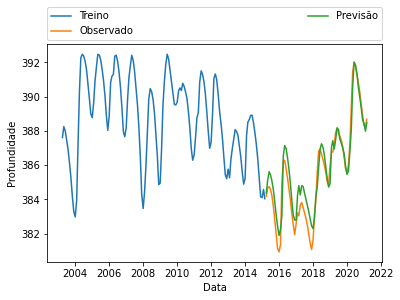

In [12]:
# RECUPERA OS VALORES ORIGINAIS DO SCALER

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# IMPRIME O ERRO POR MÉDIA QUADRÁTICA, COMPARANDO OS VALORES PREVISTOS COM OS REAIS.

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


# IMPRIME O GRÁFICO COM A PREVISÃO

train = new_data[:train_size]
test = new_data[train_size:].copy()

test['Predictions'] = testPredict
#test.loc[:,'Predictions'] = testPredict   #Adiciona a coluna

plt.ylabel('Profundidade')
plt.xlabel('Data')

plt.plot(train['Profundidade'], label='Treino')
plt.plot(test['Profundidade'], label = 'Observado')
plt.plot(test['Predictions'], label = 'Previsão')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.show()
